# Lecture 8.2: Train Convolutional Neural Networks

## Chapter Learning Objectives
<hr>

- Load image data using `torchvision.datasets.ImageFolder()` to train a network in PyTorch.

## Imports
<hr>

In [11]:

!pip install torchvision
!pip install memory_profiler

import json
import numpy as np
import pandas as pd
from collections import OrderedDict
import torch
import torchvision
from torch import nn, optim
from torchvision.utils import make_grid
from torchvision import transforms, models, datasets
from torchsummary import summary
from PIL import Image
import matplotlib.pyplot as plt
import memory_profiler  # conda install -c anaconda memory_profiler  |  conda install -c conda-forge memory_profiler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
# from utils.plotting import *

## 1. Datasets, Dataloaders, and Transforms
<hr>

### 1.1. Preparing Data

`torch` and `torchvision` provide out-of-the-box functionality for loading in lots of different kinds of data. The way you create a dataloader depends on the data you have (i.e., do you have numpy arrays, tensors, images, or something else?) and the PyTorch docs [can help you out](https://pytorch.org/docs/stable/data.html#dataset-types)

Loading data into PyTorch is usually a two-step process:
1. Create a `dataset` (this is your raw data)
2. Create a `dataloader` (this will help you batch your data)

Working with CNNs and images, you'll mostly be using `torchvision.datasets.ImageFolder()` ([docs](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder)), it's very easy to use. It assumes you have a directory structure with sub-directories for each class like this:

```
data
│
├── class_1
│   ├── image_1.png 
│   ├── image_2.png
│   ├── image_3.png
│   └── etc.
└── class_2
    ├── image_1.png 
    ├── image_2.png
    ├── image_3.png
    └── etc.
```

For example, consider the training dataset we have in the current directory at `data/bitmoji_rgb`:

```
bitmoji_rgb
└── train
    ├── not_tom
    │   ├── image_1.png 
    │   ├── image_2.png
    │   ├── image_3.png
    │   └── etc.
    └── tom
        ├── image_1.png 
        ├── image_2.png
        ├── image_3.png
        └── etc.
```

In [16]:
TRAIN_DIR = "data/bitmoji_rgb/train/"

mem = memory_profiler.memory_usage()[0]
train_dataset = torchvision.datasets.ImageFolder(root=TRAIN_DIR)
print(f"Memory consumed: {memory_profiler.memory_usage()[0] - mem:.0f} mb")

Memory consumed: 0 mb


Notice how our memory usage is the same, we aren't loading anything in yet, just making PyTorch aware of what kind of data we have and where it is. We can now check various information about our `train_dataset`:

In [18]:
print(f"Classes: {train_dataset.classes}")
print(f"Class count: {train_dataset.targets.count(0)}, {train_dataset.targets.count(1)}")
print(f"Samples:",len(train_dataset))
print(f"First sample: {train_dataset.samples[0]}")

Classes: ['not_tom', 'tom']
Class count: 857, 857
Samples: 1714
First sample: ('data/bitmoji_rgb/train/not_tom\\bitmoji_10187.png', 0)


Now, we could start working with this dataset directly. For example, here's the first sample:

Class: not_tom


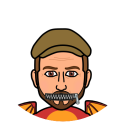

In [20]:
img, target = next(iter(train_dataset))
print(f"Class: {train_dataset.classes[target]}")
img

But often we want to apply some pre-processing to our data. For example, `ImageFolder` loads our data using the `PIL` package, but we need tensors! 

In [23]:
print(f"Image data type: {type(img)}")
print(f"     Image size: {img.size}")

Image data type: <class 'PIL.Image.Image'>
     Image size: (128, 128)


## 1.2 Transforms

Any pre-processing we wish to apply to our images is done using `torchvision.transforms`. There are a lot of transformation options here - we'll explore some more later - for now, we'll `Resize()` our images and convert them `ToTensor()`. We use `transforms.Compose()` to chain multiple transformations together:

In [30]:
IMAGE_SIZE = 64

data_transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.ImageFolder(root=TRAIN_DIR,
                                                 transform=data_transforms)
img, target = next(iter(train_dataset))
print(f"Image data type: {type(img)}")
print(f"     Image size: {img.shape}")

Image data type: <class 'torch.Tensor'>
     Image size: torch.Size([3, 64, 64])


Okay cool, but there's one more issue: we want to work with **batches** of data, because most of the time, we won't be able to fit an entire dataset into RAM at once (especially when it comes to image data). This is where PyTorch's `dataloader` comes in. It allows us to specify how we want to batch our data:

In [33]:
BATCH_SIZE = 64

mem = memory_profiler.memory_usage()[0]
train_loader = torch.utils.data.DataLoader(train_dataset,          # our raw data
                                           batch_size=BATCH_SIZE,  # the size of batches we want the dataloader to return
                                           shuffle=True,           # shuffle our data before batching
                                           drop_last=False)        # don't drop the last batch even if it's smaller than batch_size
print(f"Memory consumed: {memory_profiler.memory_usage()[0] - mem:.0f} mb")

Memory consumed: 0 mb


Once again, we aren't loading anything yet, we just prepared the loader. We can now query the loader to return a batch of data (this will consume memory):

In [36]:
mem = memory_profiler.memory_usage()[0]
imgs, targets = next(iter(train_loader))
print(f"       # of batches: {len(train_loader)}")
print(f"    Image data type: {type(imgs)}")
print(f"   Image batch size: {imgs.shape}")  # dimensions are (batch size, image channels, image height, image width)
print(f"  Target batch size: {targets.shape}")
print(f"       Batch memory: {memory_profiler.memory_usage()[0] - mem:.2f} mb")  # memory usage after loading batch

       # of batches: 27
    Image data type: <class 'torch.Tensor'>
   Image batch size: torch.Size([64, 3, 64, 64])
  Target batch size: torch.Size([64])
       Batch memory: 6.84 mb


### Preparing valid set

In [38]:
VALID_DIR = "data/bitmoji_rgb/valid/"
valid_dataset = datasets.ImageFolder(root=VALID_DIR, transform=data_transforms)

validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

### Plot samples

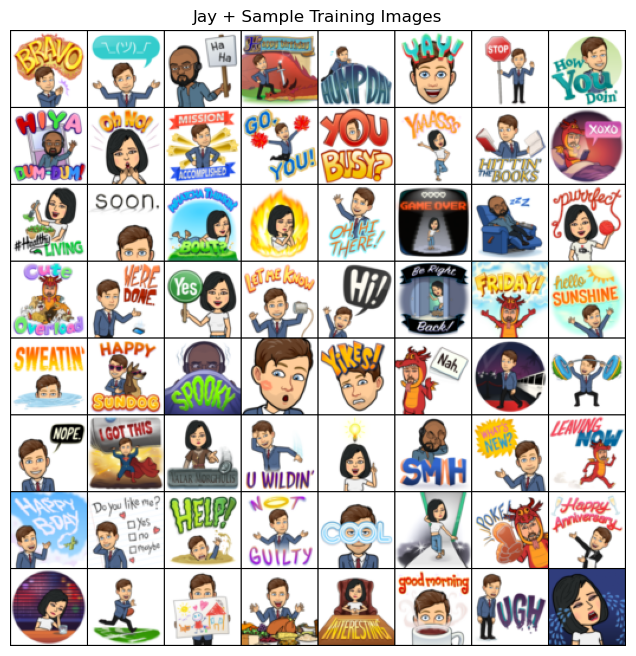

In [42]:

# Plot samples
sample_batch = next(iter(train_loader))
plt.figure(figsize=(10, 8)); plt.axis("off"); plt.title("Jay + Sample Training Images")
plt.imshow(np.transpose(make_grid(sample_batch[0], padding=1, normalize=True),(1,2,0)));

## 2. Building a CNN model
<hr>

In [47]:
class bit_train_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 8, (5, 5)), # - 3 input channels (RGB images) - 8 output channels (feature maps)  - Kernel size of 5x5
            nn.ReLU(),
            nn.MaxPool2d((2, 2)), #- Kernel size of 2x2 (reduces dimensions by half)
            nn.Conv2d(8, 4, (3, 3)), # - 8 input channels (from the previous convolutional layer) - 4 output channels (feature maps)  - Kernel size of 3x3
            nn.ReLU(),
            nn.MaxPool2d((3, 3)), #  Max Pooling Layer: Further reduces the spatial dimensions - Kernel size of 3x3
            nn.Flatten(),         # Flatten Layer: Converts the multi-dimensional feature maps into a 1D vector
            nn.Linear(324, 128), # First Fully Connected (Linear) Layer: Connects the flattened input to 128 neurons  - Input size: 324 (flattened size after convolutions and pooling) - Output size: 128 (hidden layer)
            nn.ReLU(),
            nn.Linear(128, 1) # Second Fully Connected (Linear) Layer: Maps the 128 neurons to a single output neuron - Input size: 128 (hidden layer) - Output size: 1 (final prediction, e.g., binary classification)
        )
        
    def forward(self, x):
        out = self.main(x)
        return out

In [49]:
def trainer(model, criterion, optimizer, trainloader, validloader, epochs=5, verbose=True):
    """
    Train and validate a PyTorch model.
    
    Args:
        model: PyTorch model to train.
        criterion: Loss function.
        optimizer: Optimizer for updating weights.
        trainloader: DataLoader for training data.
        validloader: DataLoader for validation data.
        epochs: Number of epochs for training.
        verbose: If True, print progress for each epoch.
    
    Returns:
        A dictionary containing training loss, validation loss, and validation accuracy.
    """
    
    train_loss, valid_loss, valid_accuracy = [], [], []
    for epoch in range(epochs):  # for each epoch
        train_batch_loss = 0
        valid_batch_loss = 0
        valid_batch_acc = 0
        
        # Training
        model.train()
        for X, y in trainloader:
            optimizer.zero_grad() # Reset gradients
            y_hat = model(X).flatten() # Forward pass: compute the model's prediction
            loss = criterion(y_hat, y.type(torch.float32)) # Compute loss between predicted values and actual labels
            loss.backward() # Backpropagation: compute gradients
            optimizer.step() # Update model parameters using optimizer
            train_batch_loss += loss.item() # Accumulate batch loss
        train_loss.append(train_batch_loss / len(trainloader)) # Compute average training loss for this epoch
        
        # Validation
        model.eval() # Set the model to evaluation mode (disables dropout/batchnorm layers if any)
        with torch.no_grad():  # this stops pytorch doing computational graph stuff under-the-hood and saves memory and time
            for X, y in validloader:
                y_hat = model(X).flatten() # Forward pass: compute predictions for validation set
                y_hat_labels = torch.sigmoid(y_hat) > 0.5 # Apply sigmoid activation and classify outputs (threshold at 0.5)
                loss = criterion(y_hat, y.type(torch.float32)) # Compute validation loss
                valid_batch_loss += loss.item() # Accumulate validation batch loss
                valid_batch_acc += (y_hat_labels == y).type(torch.float32).mean().item() # Compute validation accuracy: compare predicted labels to actual labels
        valid_loss.append(valid_batch_loss / len(validloader)) # Compute average validation loss for this epoch
        valid_accuracy.append(valid_batch_acc / len(validloader))  # Compute average validation accuracy for this epoch
        
        # Print progress
        if verbose:
            print(f"Epoch {epoch + 1}:",
                  f"Train Loss: {train_loss[-1]:.3f}.",
                  f"Valid Loss: {valid_loss[-1]:.3f}.",
                  f"Valid Accuracy: {valid_accuracy[-1]:.2f}.")
    
    results = {"train_loss": train_loss,
               "valid_loss": valid_loss,
               "valid_accuracy": valid_accuracy}
    return results    

### 2.1 Define and train model

In [64]:
# Define and train model
model = bit_train_CNN()

# Define the loss function
# nn.BCEWithLogitsLoss() combines a sigmoid activation with binary cross-entropy loss
# This is typically used for binary classification problems
criterion = nn.BCEWithLogitsLoss() 


#Define the optimizer
# optim.Adam() is an Adam optimizer that adjusts the model's weights using gradients
# model.parameters() ensures the optimizer updates all trainable model parameters
optimizer = optim.Adam(model.parameters()) # where is learning rate?

#Train the model using the trainer function
results = trainer(model, criterion, optimizer, train_loader, validloader, epochs=35)

Epoch 1: Train Loss: 0.690. Valid Loss: 0.683. Valid Accuracy: 0.52.
Epoch 2: Train Loss: 0.665. Valid Loss: 0.637. Valid Accuracy: 0.66.
Epoch 3: Train Loss: 0.641. Valid Loss: 0.614. Valid Accuracy: 0.69.
Epoch 4: Train Loss: 0.630. Valid Loss: 0.604. Valid Accuracy: 0.71.
Epoch 5: Train Loss: 0.600. Valid Loss: 0.573. Valid Accuracy: 0.73.
Epoch 6: Train Loss: 0.577. Valid Loss: 0.554. Valid Accuracy: 0.72.
Epoch 7: Train Loss: 0.557. Valid Loss: 0.521. Valid Accuracy: 0.71.
Epoch 8: Train Loss: 0.537. Valid Loss: 0.506. Valid Accuracy: 0.76.
Epoch 9: Train Loss: 0.518. Valid Loss: 0.505. Valid Accuracy: 0.76.
Epoch 10: Train Loss: 0.490. Valid Loss: 0.460. Valid Accuracy: 0.81.
Epoch 11: Train Loss: 0.494. Valid Loss: 0.491. Valid Accuracy: 0.77.
Epoch 12: Train Loss: 0.470. Valid Loss: 0.437. Valid Accuracy: 0.80.
Epoch 13: Train Loss: 0.442. Valid Loss: 0.432. Valid Accuracy: 0.83.
Epoch 14: Train Loss: 0.424. Valid Loss: 0.416. Valid Accuracy: 0.82.
Epoch 15: Train Loss: 0.416. 

### 2.2. Saving and Loading PyTorch Models

The [PyTorch documentation](https://pytorch.org/tutorials/beginner/saving_loading_models.html) about saving and loading models is fantastic and the process is very easy. It's common PyTorch convention to save models using either a `.pt` or `.pth` file extension. It is recommended that you just save your model learned parameters from `model.state_dict()`:

```python
# Save model
PATH = "models/my_model.pt"
torch.save(model.state_dict(), PATH)     # save model at PATH
# Load model
model = MyModelClass()                   # create an instance of the model
model.load_state_dict(torch.load(PATH))  # load model from PATH
```

If you're using the model for inference (not training), make sure to switch it to eval mode: `model.eval()`. There are other options for saving models, in particular, if you want to save a model and continue training it later, you'll want to save other necessary information like the optimizer state, the epoch you're on, etc. This is all documented here in the [PyTorch docs](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-a-general-checkpoint-for-inference-and-or-resuming-training).



### Save your Model 1 - regular model

In [82]:
# Please Save your model 1
PATH = "models/train1.pt"
# PATHExample = "models/bit_train_CNN_acc85.pt" 
torch.save(model, PATH)

In [85]:
# load model
PATH = "models/train1.pt" #load your path
model = bit_train_CNN()
model.load_state_dict(torch.load(PATH))
model.eval()

UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL __main__.bit_train_CNN was not an allowed global by default. Please use `torch.serialization.add_safe_globals([bit_train_CNN])` or the `torch.serialization.safe_globals([bit_train_CNN])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

## 3. Data Augmentation
<hr>

Data augmentation is used for two main purposes:
1. Make your CNN more robust to scale/rotation/translation in your images
2. Increase the size of your training set

Let's explore point 1 a bit further. We can see below is a Bitmoji of Tom, does the CNN we loaded above predict this?

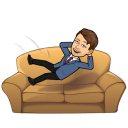

In [129]:
image = Image.open('img/tom-bitmoji.png')
image

In [131]:
IMAGE_SIZE = 64 # Define the desired image size for the model input
# Resize the input image to the specified IMAGE_SIZE and convert it to a tensor
# The unsqueeze(0) adds a batch dimension, as the model expects batched input
image_tensor = transforms.functional.to_tensor(image.resize((IMAGE_SIZE, IMAGE_SIZE))).unsqueeze(0) 

# Pass the image tensor through the model, apply sigmoid activation to get probabilities
# Convert the probability into a binary prediction (0 or 1) using a threshold of 0.5
prediction = int(torch.sigmoid(model(image_tensor)) > 0.5)

# Print the class corresponding to the prediction using the train_dataset's class list
print(f"Prediction: {train_dataset.classes[prediction]}")

Prediction: not_tom


Looks good! But what happens if I flip my image. You can still tell it's me, but can my CNN?

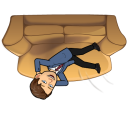

In [134]:
image = image.rotate(180)
image

In [136]:
image_tensor = transforms.functional.to_tensor(image.resize((IMAGE_SIZE, IMAGE_SIZE))).unsqueeze(0)
prediction = int(torch.sigmoid(model(image_tensor)) > 0.5)
print(f"Prediction: {train_dataset.classes[prediction]}")

Prediction: not_tom


Well that's problematic. We'd like our CNN to be robust against these kinds of differences. We can expose our CNN to flipped images, so that it can learn to better predict them, with data augmentation. Common image augmentations include:
- rotation/flipping
- cropping
- adding noise
- You can view others in the [PyTorch docs](https://pytorch.org/docs/stable/torchvision/transforms.html)

We add transforms just like we did previously, using the `transform` argument of `torchvision.datasets.ImageFolder()`:

In [139]:
data_transforms = transforms.Compose([
    transforms.RandomVerticalFlip(p=0.5), # Randomly flip the image vertically with a probability of 0.5
    transforms.RandomRotation(degrees=20), # Randomly rotate the image by up to ±20 degrees
    transforms.Resize(IMAGE_SIZE), # Resize the image to a fixed size defined by IMAGE_SIZE
    transforms.ToTensor() # Convert the image to a PyTorch tensor and scale pixel values to [0, 1]
])

train_dataset = torchvision.datasets.ImageFolder(root=TRAIN_DIR,
                                                 transform=data_transforms)
train_loader_augmented = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True,
                                           drop_last=False)
sample_batch, target = next(iter(train_loader_augmented))


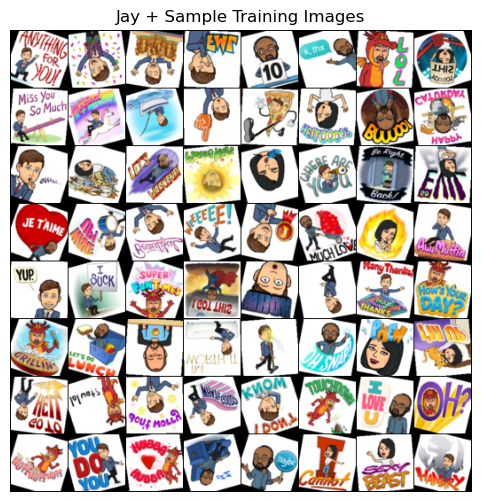

In [141]:
# Visualize the augmented images
from torchvision.utils import make_grid
plt.figure(figsize=(8, 6))
plt.axis("off")
plt.title("Jay + Sample Training Images")

plt.imshow(np.transpose(make_grid(sample_batch, padding=1, normalize=True),(1,2,0)));
plt.show()

### 3.1 Train the augmented model

In [145]:
# GPU available?
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using: {device}")
# Model
model = bit_train_CNN()
model.to(device);

Using: cpu


In [147]:
# Define and train model
model = bit_train_CNN()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters())
results = trainer(model, criterion, optimizer, train_loader_augmented, validloader, epochs=50)

Epoch 1: Train Loss: 0.694. Valid Loss: 0.691. Valid Accuracy: 0.54.
Epoch 2: Train Loss: 0.691. Valid Loss: 0.688. Valid Accuracy: 0.51.
Epoch 3: Train Loss: 0.687. Valid Loss: 0.674. Valid Accuracy: 0.60.
Epoch 4: Train Loss: 0.675. Valid Loss: 0.653. Valid Accuracy: 0.64.
Epoch 5: Train Loss: 0.654. Valid Loss: 0.643. Valid Accuracy: 0.63.
Epoch 6: Train Loss: 0.642. Valid Loss: 0.629. Valid Accuracy: 0.68.
Epoch 7: Train Loss: 0.641. Valid Loss: 0.623. Valid Accuracy: 0.69.
Epoch 8: Train Loss: 0.612. Valid Loss: 0.604. Valid Accuracy: 0.67.
Epoch 9: Train Loss: 0.595. Valid Loss: 0.568. Valid Accuracy: 0.72.
Epoch 10: Train Loss: 0.579. Valid Loss: 0.583. Valid Accuracy: 0.70.
Epoch 11: Train Loss: 0.560. Valid Loss: 0.528. Valid Accuracy: 0.75.
Epoch 12: Train Loss: 0.537. Valid Loss: 0.489. Valid Accuracy: 0.80.
Epoch 13: Train Loss: 0.514. Valid Loss: 0.493. Valid Accuracy: 0.79.
Epoch 14: Train Loss: 0.499. Valid Loss: 0.489. Valid Accuracy: 0.77.
Epoch 15: Train Loss: 0.486. 

### Save your Model 2 - Augmented Model

In [149]:
# Your code

PATH = "models/bitmoji_cnn_augmented.pt"
torch.save(model, PATH)

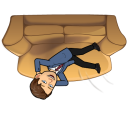

In [150]:
image

In [151]:
image_tensor = transforms.functional.to_tensor(image.resize((IMAGE_SIZE, IMAGE_SIZE))).unsqueeze(0)
prediction = int(torch.sigmoid(model(image_tensor)) > 0.5)
print(f"Prediction: {train_dataset.classes[prediction]}")

Prediction: tom


### 3.2 Visualize loss and accuracy 

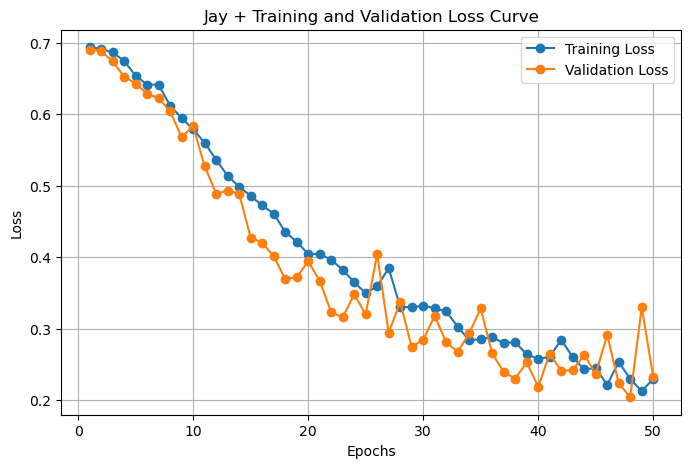

In [153]:
import matplotlib.pyplot as plt

# Extract metrics from the results dictionary
train_loss = results["train_loss"]       # Training loss per epoch
valid_loss = results["valid_loss"]       # Validation loss per epoch


# Plot Training and Validation Loss Curve
plt.figure(figsize=(8, 5))  # Set the figure size
plt.plot(range(1, len(train_loss) + 1), train_loss, label="Training Loss", marker='o')  # Training loss
plt.plot(range(1, len(valid_loss) + 1), valid_loss, label="Validation Loss", marker='o')  # Validation loss
plt.xlabel("Epochs")  # X-axis label
plt.ylabel("Loss")  # Y-axis label
plt.title("Jay + Training and Validation Loss Curve")  # Plot title
plt.legend()  # Add a legend
plt.grid()  # Add grid lines for better readability
plt.show()

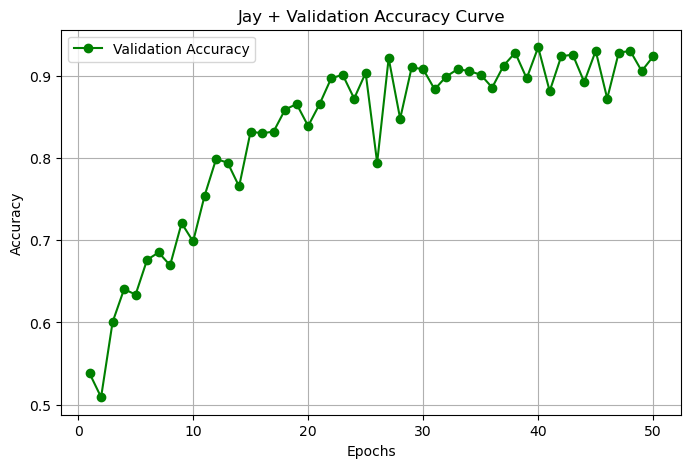

In [154]:
# Plot Validation Accuracy Curve

valid_accuracy = results["valid_accuracy"]  # Validation accuracy per epoch

plt.figure(figsize=(8, 5))  # Set the figure size
plt.plot(range(1, len(valid_accuracy) + 1), valid_accuracy, label="Validation Accuracy", color='green', marker='o')
plt.xlabel("Epochs")  # X-axis label
plt.ylabel("Accuracy")  # Y-axis label
plt.title("Jay + Validation Accuracy Curve")  # Plot title
plt.legend()  # Add a legend
plt.grid()  # Add grid lines for better readability
plt.show()